# Table of contents 
- [Setup](#setup)
    - [Purpose](#purpose)
    - [Libraries](#libraries) 
- [OpenAlex Reuse](#OpenAlexReuse)
    - [OpenAlex repository](#OpenAlexRepository)
    - [Material URLs in OpenAlex Fulltext Works](#materialURLsinOpenAlexFulltextWorks)
- [](#)
- [References](#references)


<a name='setup'></a>
# 0. Setup 

This notebook contains the code to investigate the extent of dataset reuse; specifically the reuse of the datasets used in the articles published in NeuroImage in 2022. 

<a name='purpose'></a>
## 0.1. Purpose 

The purpose of this notebook is to investigate how many other articles across articles available in OpenAlex use the same datasets as those used by the researchers who published their work in NeuroImage in 2022. 
This notebook draws on the work by Theó Sourget (2023a, 2023b), who similarly investigated the usage of a select couple of datasets. 

<a name='libraries'></a>
## 0.2. Libraries 

In [108]:
import pandas as pd 
import numpy as np 
import csv
import re
import json
import os
import ast 

import time
import requests
from requests.adapters import HTTPAdapter
from requests.adapters import Retry
from urllib3.util.retry import Retry

# Matplotlib for visualisations (Hunter 2007)
import matplotlib.pyplot as plt

In [109]:
# Reuse of the links: how many use each of the links in urls = pd.read_csv('../Data/material_URLs.csv')

In [110]:
# The filtered_articles_all_urls.csv have links like creativecommons.org removed 
articles_df = pd.read_csv('../Data/articles_filtered_urls.csv')
articles_dois = pd.read_csv('../Data/ElsevierAPI/articles_doi.csv')
material_urls = pd.read_csv('../Data/material_URLs.csv')
classified_df = pd.read_csv('../Data/classified_data.csv')

In [111]:
articles_dois = articles_dois.rename(columns={"DOIs": "DOI"})
articles_dois['DOI'] = articles_dois['DOI'].str.replace('.pdf', '', regex=False)

In [112]:
len(material_urls)

305

<a name='OpenAlexReuse'></a>
# 1. OpenAlex reuse

You can use the search query parameters to search for various search terms across titles, abstracts, and full text (if the text has the full text available). 
I need to use the fulltext.search OpenAlexAPI (Filter works). 


References: 
- OpenAlexAPI. (n.d.-a). Filter works. OpenAlex API Documentation. Retrieved September 14, 2023, from https://docs.openalex.org/api-entities/works/filter-works
- OpenAlexAPI. (n.d.). Search Works. Retrieved November 23, 2023, from https://docs.openalex.org/api-entities/works/search-works

<a name='OpenAlexRepository'></a>
## 1.1. OpenAlex repository
I want to know how many works are currently available on OpenAlex and how many has fulltext available. 

In [79]:
OpenAlexWorks_total = requests.get(f'https://api.openalex.org/works').json()
OpenAlexWorks_total_count = OpenAlexWorks_total['meta']['count']

In [80]:
OpenAlexWorks_total['meta']

{'count': 246507581,
 'db_response_time_ms': 27,
 'page': 1,
 'per_page': 25,
 'groups_count': None}

In [81]:
OpenAlexWorks_fulltext = requests.get(f'https://api.openalex.org/works?filter=has_fulltext:True').json()
OpenAlexWorks_fulltext_count = OpenAlexWorks_fulltext['meta']['count']

In [82]:
OpenAlexWorks_fulltext['meta']

{'count': 72973400,
 'db_response_time_ms': 95,
 'page': 1,
 'per_page': 25,
 'groups_count': None}

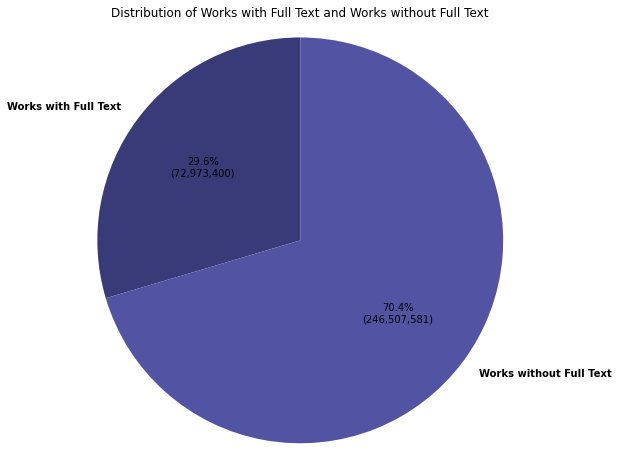

In [83]:
# Calculate the percentage
percentage = (OpenAlexWorks_fulltext_count / OpenAlexWorks_total_count) * 100

# Create data for the pie chart
labels = ['Works with Full Text', 'Works without Full Text']
sizes = [OpenAlexWorks_fulltext_count, OpenAlexWorks_total_count - OpenAlexWorks_fulltext_count]
colors = plt.cm.tab20b.colors[:2]  # Use only the first two colors from tab20b colormap

# Set a larger figure size
fig1, ax1 = plt.subplots(figsize=(8, 8))

# Plot the pie chart
patches, texts, autotexts = ax1.pie(sizes, labels=labels, autopct=lambda p: f'{p:.1f}%', startangle=90, colors=colors)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')

# Add percentages and raw counts under the circle
for i, (text, autotext) in enumerate(zip(texts, autotexts)):
    text.set(size=10, weight='bold')
    autotext.set(size=10, weight='normal')
    # Place raw count above the percentage
    if i == 0:
        autotext.set_text(f'{autotext.get_text()}\n({OpenAlexWorks_fulltext_count:,})')
    elif i == 1:
        autotext.set_text(f'{autotext.get_text()}\n({OpenAlexWorks_total_count:,})')

# Set title
plt.title('Distribution of Works with Full Text and Works without Full Text')
plt.savefig('../Results/graphics/OpenAlex_TotalWorksWithFullTextDistribution.png')

plt.show()

<a name='materialURLsinOpenAlexFulltextWorks'></a>
## 1.2. Material URLs in OpenAlex fulltext works 

### 1.2.1. Test with a single link
Get the texts that has one specific link

In [84]:
sources = requests.get(f'https://api.openalex.org/works?search=https://humanconnectome.org').json()

In [85]:
sources['meta']

{'count': 229,
 'db_response_time_ms': 116,
 'page': 1,
 'per_page': 25,
 'groups_count': None}

In [86]:
len(sources['results'])

25

Searching for the URLs individually returns different numbers 

    https://api.openalex.org/works?filter=fulltext.search:(humanconnectome.org)

I get 243 matches - and for the other searches in the (), I search the following and get these numbers 

    https://humanconnectome.org - count is = 229
    https://www.humanconnectome.org - count is = 624
    http://humanconnectome.org - count is = 229
    http://www.humanconnectome.org - count is= 624
    www.humanconnectome.org - count is = 645

some of them might have overlapping articles. 

https://api.openalex.org/works?filter=fulltext.search:(humanconnectome.org%20OR%20https://humanconnectome.org%20OR%20https://www.humanconnectome.org%20OR%20http://humanconnectome.org%20OR%20http://www.humanconnectome.org%20OR%20www.humanconnectome.org)

return 10,113,496 counts.

The first query:
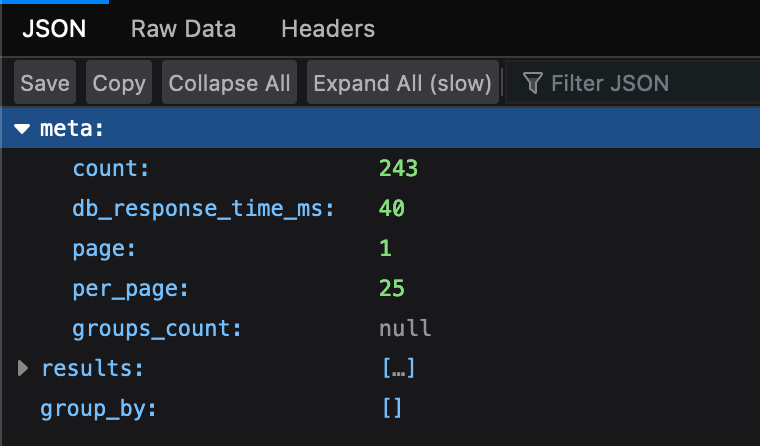

The second query: 
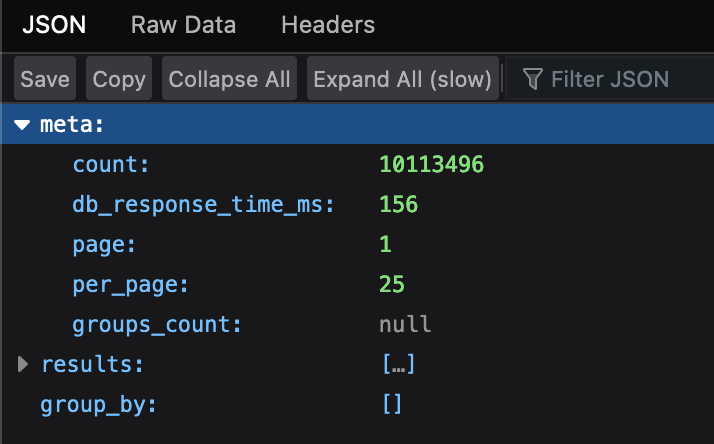


In [114]:
def make_session():
    """Create and return a session object for making HTTP requests.
    """
    session = requests.Session()
    retries = Retry(total=5, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
    session.mount('http://', HTTPAdapter(max_retries=retries))
    session.mount('https://', HTTPAdapter(max_retries=retries))
    return session

def fetch_unique_results(url, session):
    """Fetch information about articles from OpenAlex API using pagination for a given URL.
    """
    all_results = []
    processed_dois = set()
    url_prefixes = ['', 'https://', 'https://www.', 'http://', 'http://www.', 'www.']

    for prefix in url_prefixes:
        current_url = f'{prefix}{url}'
        page = 1 
        cursor = "*"

        while cursor is not None: 
            api_url = f'https://api.openalex.org/works?filter=fulltext.search:{current_url}&per_page=50&cursor={cursor}'
            response = session.get(api_url)
            if response.status_code == 200:
                data = response.json()
                articles_on_page = data.get("results", [])

                if not articles_on_page: 
                    break
                
                for result in articles_on_page:
                    doi = result.get('doi', '')
                    if doi in processed_dois:
                        continue
                    all_results.append(result)
                    processed_dois.add(doi)
                
                # Update the cursor for the next iteration
                cursor = data.get("meta", {}).get("next_cursor")
                
                page += 1
                time.sleep(0.1)  # Introduce a delay to comply with rate limits
            
            elif response.status_code == 403:
                print("Error fetching data. Status code:", response.status_code)
                print("Waiting and retrying...")
                time.sleep(60)  # Wait for a minute before retrying
            
            else:
                print("Error fetching data. Status code:", response.status_code)
                if response.status_code == 429:
                    # Exponential backoff in case of rate limiting (status code 429)
                    delay = 2 ** (page - 1)
                    time.sleep(delay)
                    print(f"Retrying after {delay} seconds...")
                else:
                    break

    return all_results

def process_material_urls(material_urls):
    """Process material URLs, fetches information about articles, and checks for statistical terms.
    """
    session = make_session()
    for material_url in material_urls:
        articles_info = fetch_unique_results(material_url, session)
        
        if not articles_info:
            print(f"For material URL {material_url}: No articles found.")
            continue

        # Check statistical terms in each article and update the information
        #for article_info in articles_info:
            #contains_statistical_terms = check_statistical_terms(article_info['id'], session)
            #article_info['contains_statistical_terms'] = contains_statistical_terms
        
        # Save the information to a JSON file
        combined_save_path = f'../Results/OpenAlexReuse/MaterialURLReuse/{material_url.replace("/", "_")}.json'
        with open(combined_save_path, 'w') as combined_json_file:
            json.dump(articles_info, combined_json_file, indent=2)

        # Calculate and print statistics
        print(f"For material URL {material_url}:")
        print(f"Number of articles: {len(articles_info)}")
        #print(f"Number of articles containing statistical terms: {sum(article['contains_statistical_terms'] for article in articles_info)}")
        print("=" * 50)

In [99]:
api_url = 'humanconnectome.org'
session = make_session()

In [100]:
all_results = pd.DataFrame(fetch_unique_results(api_url, session))

https://api.openalex.org/works?filter=fulltext.search:humanconnectome.org&per_page=50&cursor=*
https://api.openalex.org/works?filter=fulltext.search:humanconnectome.org&per_page=50&cursor=IlsyNDAuMTk2NDEsIDE1Mjc4MTEyMDAwMDAsICdodHRwczovL29wZW5hbGV4Lm9yZy9XMjc1MjczODY2MCddIg==
https://api.openalex.org/works?filter=fulltext.search:humanconnectome.org&per_page=50&cursor=IlsxNDUuMDkxNjEsIDE2NTY5NzkyMDAwMDAsICdodHRwczovL29wZW5hbGV4Lm9yZy9XNDI4MzgxMjk4MiddIg==
https://api.openalex.org/works?filter=fulltext.search:humanconnectome.org&per_page=50&cursor=Ils4My45NTkzMSwgMTU2MDgxNjAwMDAwMCwgJ2h0dHBzOi8vb3BlbmFsZXgub3JnL1cyOTQ5NzI2MzU2J10i
https://api.openalex.org/works?filter=fulltext.search:humanconnectome.org&per_page=50&cursor=IlszOC43NTQ2MywgMTY4NDk3MjgwMDAwMCwgJ2h0dHBzOi8vb3BlbmFsZXgub3JnL1c0Mzc4MTczMDA5J10i
https://api.openalex.org/works?filter=fulltext.search:humanconnectome.org&per_page=50&cursor=IlswLjAsIDE2OTM3ODU2MDAwMDAsICdodHRwczovL29wZW5hbGV4Lm9yZy9XNDM4NjQxNTc4MSddIg==
https://api

In [101]:
all_results

,id,doi,title,display_name,relevance_score,publication_year,publication_date,ids,language,primary_location,...,referenced_works_count,referenced_works,related_works,ngrams_url,abstract_inverted_index,cited_by_api_url,counts_by_year,updated_date,created_date,is_authors_truncated
0,https://openalex.org/W2507387536,https://doi.org/10.1038/nn.4361,The Human Connectome Project's neuroimaging ap...,The Human Connectome Project's neuroimaging ap...,1323.273900,2016,2016-08-26,{'openalex': 'https://openalex.org/W2507387536...,en,"{'is_oa': False, 'landing_page_url': 'https://...",...,114,"[https://openalex.org/W152769478, https://open...","[https://openalex.org/W2951401594, https://ope...",https://api.openalex.org/works/W2507387536/ngrams,"{'Noninvasive': [0], 'human': [1], 'neuroimagi...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2023, 'cited_by_count': 98}, {'year'...",2023-11-25T09:29:11.600108,2016-09-16,NaN
1,https://openalex.org/W2499800833,https://doi.org/10.1038/nature18933,A multi-modal parcellation of human cerebral c...,A multi-modal parcellation of human cerebral c...,1276.273700,2016,2016-07-20,{'openalex': 'https://openalex.org/W2499800833...,en,"{'is_oa': False, 'landing_page_url': 'https://...",...,41,"[https://openalex.org/W1549290346, https://ope...","[https://openalex.org/W2516703657, https://ope...",https://api.openalex.org/works/W2499800833/ngrams,"{'Understanding': [0], 'the': [1, 38, 119, 129...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2023, 'cited_by_count': 508}, {'year...",2023-11-27T04:13:17.301387,2016-08-23,NaN
2,https://openalex.org/W2096672020,https://doi.org/10.1016/j.neuroimage.2013.05.039,Resting-state fMRI in the Human Connectome Pro...,Resting-state fMRI in the Human Connectome Pro...,954.000900,2013,2013-10-01,{'openalex': 'https://openalex.org/W2096672020...,en,"{'is_oa': False, 'landing_page_url': 'https://...",...,55,"[https://openalex.org/W176484045, https://open...","[https://openalex.org/W3082461017, https://ope...",https://api.openalex.org/works/W2096672020/ngrams,"{'Resting-state': [0], 'functional': [1, 10, 7...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2023, 'cited_by_count': 136}, {'year...",2023-11-25T09:18:07.505989,2016-06-24,NaN
3,https://openalex.org/W2766639217,https://doi.org/10.1038/s41467-017-01285-x,The challenge of mapping the human connectome ...,The challenge of mapping the human connectome ...,791.972840,2017,2017-11-07,{'openalex': 'https://openalex.org/W2766639217...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",...,78,"[https://openalex.org/W14464931, https://opena...","[https://openalex.org/W1965402735, https://ope...",https://api.openalex.org/works/W2766639217/ngrams,"{'Tractography': [0], 'based': [1, 116], 'on':...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2023, 'cited_by_count': 114}, {'year...",2023-11-27T09:34:33.953487,2017-11-10,NaN
4,https://openalex.org/W2951617899,https://doi.org/10.1093/cercor/bhx179,Local-Global Parcellation of the Human Cerebra...,Local-Global Parcellation of the Human Cerebra...,715.402600,2017,2017-07-18,{'openalex': 'https://openalex.org/W2951617899...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",...,180,"[https://openalex.org/W1458229720, https://ope...","[https://openalex.org/W2951617899, https://ope...",https://api.openalex.org/works/W2951617899/ngrams,"{'A': [0], 'central': [1], 'goal': [2], 'in': ...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2023, 'cited_by_count': 364}, {'year...",2023-11-25T05:23:44.827061,2019-06-27,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,https://openalex.org/W2923969713,https://doi.org/10.1101/561811,Two fiber pathways connecting amygdala and pre...,Two fiber pathways connecting amygdala and pre...,21.831642,2019,2019-03-20,{'openalex': 'https://openalex.org/W2923969713...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",...,75,"[htt

### 1.2.2. Reuse of NeuroImage material URLs 

I want to investigate the potential reuse of all the material URLs identified in the NeuroImage 2022 articles. 

References: 
- OpenAlexAPI. (n.d.-a). Filter works. OpenAlex API Documentation. Retrieved September 14, 2023, from https://docs.openalex.org/api-entities/works/filter-works
- OpenAlexAPI. (n.d.-b). Search Works. Retrieved November 23, 2023, from https://docs.openalex.org/api-entities/works/search-works
- OpenAlexAPI. (n.d.-c). Work object. OpenAlex API Documentation. Retrieved September 17, 2023, from https://docs.openalex.org/api-entities/works/work-object#is_paratext

In [115]:
df = pd.read_csv('../Results/NeuroImage2022_materialURLs_counts.csv') # variable "material_urls_sorted" from earlier 
urls = df['Material_URL'] 

In [117]:
material_urls = process_material_urls(urls) 

For material URL surfer.nmr.mgh.harvard.edu:
Number of articles: 6469
For material URL humanconnectome.org:
Number of articles: 848
For material URL db.humanconnectome.org:
Number of articles: 200


KeyboardInterrupt: 

After running the cell for 37 hours, I stopped it: 
      Kernel status: Busy Executed 0/1 cellsElapsed time: 133719 seconds

It got information about articles containing three links 

    For material URL surfer.nmr.mgh.harvard.edu:
    Number of articles: 6469
    ==================================================
    For material URL humanconnectome.org:
    Number of articles: 848
    ==================================================
    For material URL db.humanconnectome.org:
    Number of articles: 200
    ==================================================

But the link 'clinicaltrials.gov' is used so often that it takes very long. 
There are 175,793 articles that contain the link without http://, https://, wwww. or a combination of those three in front of it. 

https://api.openalex.org/works?filter=fulltext.search:clinicaltrials.gov&per_page=50

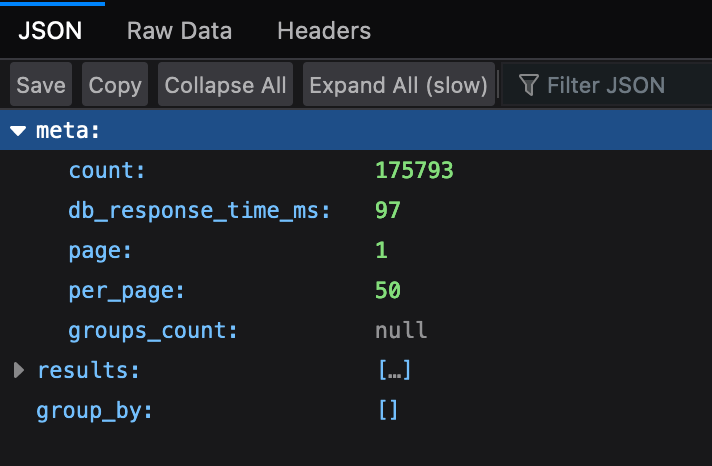

<a name='references'></a>
# 2. References
- Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering, 9(3), 90–95. https://doi.org/10.1109/MCSE.2007.55
- OpenAlexAPI. (n.d.-a). Filter works. OpenAlex API Documentation. Retrieved September 14, 2023, from https://docs.openalex.org/api-entities/works/filter-works
- OpenAlexAPI. (n.d.-b). Search Works. Retrieved November 23, 2023, from https://docs.openalex.org/api-entities/works/search-works
- OpenAlexAPI. (n.d.-c). Work object. OpenAlex API Documentation. Retrieved September 17, 2023, from https://docs.openalex.org/api-entities/works/work-object#is_paratext
- Priem, J., Piwowar, H., & Orr, R. (2022). OpenAlex: A fully-open index of scholarly works, authors, venues, institutions, and concepts. ArXiv. https://arxiv.org/abs/2205.01833
- Sourget, T. (2023a). Public_Medical_Datasets_References [Jupyter Notebook]. https://github.com/TheoSourget/Public_Medical_Datasets_References (Original work published 2023)
- Sourget, T. (2023b). TheoSourget/DDSA_Sourget: Repository used during my travel at the ITU of Copenhagen in March 2023 [Computer software]. https://github.com/TheoSourget/DDSA_Sourget
- Szucs, D., & Ioannidis, J. PA. (2020). Sample size evolution in neuroimaging research: An evaluation of highly-cited studies (1990–2012) and of latest practices (2017–2018) in high-impact journals. NeuroImage, 221, 117164. https://doi.org/10.1016/j.neuroimage.2020.117164

---

In [158]:
def fetch_all_results_pagination(url, session):
    """Fetch information about all fulltext articles from OpenAlex API using pagination for multiple URL prefixes that match a URL.

    Parameters:
    - url_list (list): List of URL suffixes to search for.
    - session (requests.Session): The session object for making requests.

    Returns:
    - list of dictionaries: Each dictionary contains information about a matching article.
    """
    all_results = []
    processed_dois = set()
    url_prefixes = ['', 'https://', 'https://www.', 'http://', 'http://www.', 'www.']


    for prefix in url_prefixes:
        current_url = f'{prefix}{url}'
        api_url = f'https://api.openalex.org/works?filter=fulltext.search:{current_url}'
        url_results = []
        page = 1
        print(api_url)

        while True:
            response = session.get(api_url, params={"page": page})
            if response.status_code == 200:
                data = response.json()
                # Extract articles from the current page and append to the list
                articles_on_page = data.get("results", [])
                for result in articles_on_page:
                    doi = result.get('doi', '')

                    if doi in processed_dois:
                        continue

                    primary_location = result.get('primary_location')
                    if primary_location is not None and isinstance(primary_location, dict):
                        source = primary_location.get('source')
                        if source is not None and isinstance(source, dict):
                            display_name = source.get('display_name', '')
                        else:
                            display_name = primary_location
                    else:
                        display_name = primary_location

                    result_info = {
                        'id': result.get('id', ''),
                        'doi': doi,
                        'title': result.get('title', ''),
                        'publication_year': result.get('publication_year', ''),
                        'display_name': display_name,
                        'type_crossref': result.get('type_crossref', ''),
                        'open_access': result.get('open_access', {}).get('is_oa', ''),
                        'cited_by_count': result.get('cited_by_count', ''),
                        'url': url  # Use the current URL
                    }
                    url_results.append(result_info)
                    processed_dois.add(doi)

                if len(articles_on_page) == 0 or page * data['meta']['per_page'] >= data['meta']['count']:
                    break

                page += 1
                time.sleep(0.1)  # Introduce a delay to comply with rate limits
            elif response.status_code == 403:
                print("Error fetching data. Status code:", response.status_code)
                print("Waiting and retrying...")
                time.sleep(60)  # Wait for a minute before retrying
            else:
                print("Error fetching data. Status code:", response.status_code)
                if response.status_code == 429:
                    # Exponential backoff in case of rate limiting (status code 429)
                    delay = 2 ** (page - 1)
                    time.sleep(delay)
                    print(f"Retrying after {delay} seconds...")
                else:
                    break            
        all_results.extend(url_results)

    return all_results

In [ ]:
def find_root_and_derivatives(urls):
    """ 
    This function performs some initial cleaning of the URLs, removing the beginning (https:// or wwww) and puts all text into lowercase. 
    Parameters: 
    :param urls(list): Sorted list of unique URLs from a dataframe
    """    
    # Remove "https://", "http://", and "www." from the URLs
    clean_urls = [url.replace("https://", "").replace("http://", "").replace("www.", "").lower() for url in urls]
    
    url_dict = {}
    for url in clean_urls:
        root = url.split('/')[0]
        # root = '/'.join(url.split('/'))
        if root in url_dict:
            url_dict[root].append(url)
        else:
            url_dict[root] = [url]

    grouped_df = pd.DataFrame(url_dict.items(), columns=['Root', 'Derivatives']).sort_values('Root', ascending=True)

    return grouped_df

test = find_root_and_derivatives(material_urls['Material_URL'])